## Define tool methods and load the data

In [61]:
import mxnet as mx
import sys,os

'''
Define batch size and the place holders for network inputs and outputs
'''

batch_size = 50 # the size of batches to train network with
print 'batch size', batch_size



batch size 50


In [62]:
import urllib2
import numpy as np
import re
import itertools
from collections import Counter

def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

def load_data_and_labels():
    """
    Loads MR polarity data from files, splits the data into words and generates labels.
    Returns split sentences and labels.
    """
    # Pull sentences with positive sentiment
    pos_file = urllib2.urlopen('https://raw.githubusercontent.com/yoonkim/CNN_sentence/master/rt-polarity.pos')

    # Pull sentences with negative sentiment
    neg_file = urllib2.urlopen('https://raw.githubusercontent.com/yoonkim/CNN_sentence/master/rt-polarity.neg')

    # Load data from files
    positive_examples = list(pos_file.readlines())
    positive_examples = [s.strip() for s in positive_examples]
    negative_examples = list(neg_file.readlines())
    negative_examples = [s.strip() for s in negative_examples]
    # Split by words
    x_text = positive_examples + negative_examples
    x_text = [clean_str(sent) for sent in x_text]
    x_text = [s.split(" ") for s in x_text]
    # Generate labels
    positive_labels = [1 for _ in positive_examples]
    negative_labels = [0 for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    return [x_text, y]


def pad_sentences(sentences, padding_word="</s>"):
    """
    Pads all sentences to the same length. The length is defined by the longest sentence.
    Returns padded sentences.
    """
    sequence_length = max(len(x) for x in sentences)
    padded_sentences = []
    for i in range(len(sentences)):
        sentence = sentences[i]
        num_padding = sequence_length - len(sentence)
        new_sentence = sentence + [padding_word] * num_padding
        padded_sentences.append(new_sentence)
    return padded_sentences


def build_vocab(sentences):
    """
    Builds a vocabulary mapping from word to index based on the sentences.
    Returns vocabulary mapping and inverse vocabulary mapping.
    """
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return [vocabulary, vocabulary_inv]


def build_input_data(sentences, labels, vocabulary):
    """
    Maps sentences and labels to vectors based on a vocabulary.
    """
    x = np.array([[vocabulary[word] for word in sentence] for sentence in sentences])
    y = np.array(labels)
    return [x, y]

def build_predict_data(sentences, vocabulary):
    """
    Maps sentences and labels to vectors based on a vocabulary.
    """
    x = np.array([[vocabulary[word] for word in sentence] for sentence in sentences])
   
    return x


"""
Loads and preprocessed data for the MR dataset.
Returns input vectors, labels, vocabulary, and inverse vocabulary.
"""
# Load and preprocess data
sentences, labels = load_data_and_labels()
sentences_padded = pad_sentences(sentences)
vocabulary, vocabulary_inv = build_vocab(sentences_padded)
x, y = build_input_data(sentences_padded, labels, vocabulary)

vocab_size = len(vocabulary)

# randomly shuffle data
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

# split train/dev set
# there are a total of 10662 labeled examples to train on
x_train, x_dev = x_shuffled[:-1000], x_shuffled[-1000:]
y_train, y_dev = y_shuffled[:-1000], y_shuffled[-1000:]

sentence_size = x_train.shape[1]

print 'Train/Dev split: %d/%d' % (len(y_train), len(y_dev))
print 'train shape:', x_train.shape
print 'dev shape:', x_dev.shape
print 'vocab_size', vocab_size
print 'sentence max words', sentence_size

Train/Dev split: 9662/1000
train shape: (9662, 56)
dev shape: (1000, 56)
vocab_size 18766
sentence max words 56


In [63]:
# define the method to load model from file:

def load_model(s_fname, p_fname):
     """
     Load model checkpoint from file.
     :return: (arg_params, aux_params)
     arg_params : dict of str to NDArray
         Model parameter, dict of name to NDArray of net's weights.
     aux_params : dict of str to NDArray
         Model parameter, dict of name to NDArray of net's auxiliary states.
     """
     symbol = mx.symbol.load(s_fname)
     save_dict = mx.nd.load(p_fname)
     arg_params = {}
     aux_params = {}
     for k, v in save_dict.items():
         tp, name = k.split(':', 1)
         if tp == 'arg':
             arg_params[name] = v
         if tp == 'aux':
             aux_params[name] = v
     return symbol, arg_params, aux_params

In [64]:
# loading the model:

f_params_file = 'cnn-0009.params'
f_symbol_file = 'cnn-symbol.json'

sym, arg_params, aux_params = load_model(f_symbol_file, f_params_file)

In [65]:
from collections import namedtuple
import time
import math

# Define the structure of our CNN Model (as a named tuple)
CNNModel = namedtuple("CNNModel", ['cnn_exec', 'symbol', 'data', 'label'])

# Define what device to train/test on
ctx=mx.gpu(0)
# If you have no GPU on your machine change this to
# ctx=mx.cpu(0)

In [66]:
cnn_exec = sym.bind(ctx=ctx, args=arg_params)


In [67]:
data = cnn_exec.arg_dict['data']
label = cnn_exec.arg_dict['softmax_label']

cnn_model= CNNModel(cnn_exec=cnn_exec, symbol=sym, data=data, label=label)

In [68]:
# Evaluate model after this epoch on dev (test) set
num_correct = 0
num_total = 0

# For each test batch
for begin in range(0, x_dev.shape[0], batch_size):
    batchX = x_dev[begin:begin+batch_size]
    batchY = y_dev[begin:begin+batch_size]

    if batchX.shape[0] != batch_size:
        continue

    cnn_model.data[:] = batchX
    cnn_model.cnn_exec.forward(is_train=False)

    num_correct += sum(batchY == np.argmax(cnn_model.cnn_exec.outputs[0].asnumpy(), axis=1))
    num_total += len(batchY)

dev_acc = num_correct * 100 / float(num_total)
print ' --- Dev Accuracy thus far: %.3f' %  dev_acc

 --- Dev Accuracy thus far: 77.600


In [71]:
#url = 'I am going to Hawaii, yippeee, and it is not long enough'
longest_sentences = 'the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the'
url = 'I am going to New York, and I am not very happy, the rock is not destined'
#url = 'the rock is not destined'

x_text = []
x_text.append(longest_sentences)

for i in range(49):
    x_text.append(url)

x_text = [s.strip() for s in x_text]
x_text = [clean_str(sent) for sent in x_text]
x_text = [s.split(" ") for s in x_text]

sentences_padded = pad_sentences(x_text)
x = build_predict_data(sentences_padded, vocabulary)

In [72]:
cnn_model.data[:] = x
cnn_model.cnn_exec.forward(is_train=False)
np.argmax(cnn_model.cnn_exec.outputs[0].asnumpy(), axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

## display the network architecture

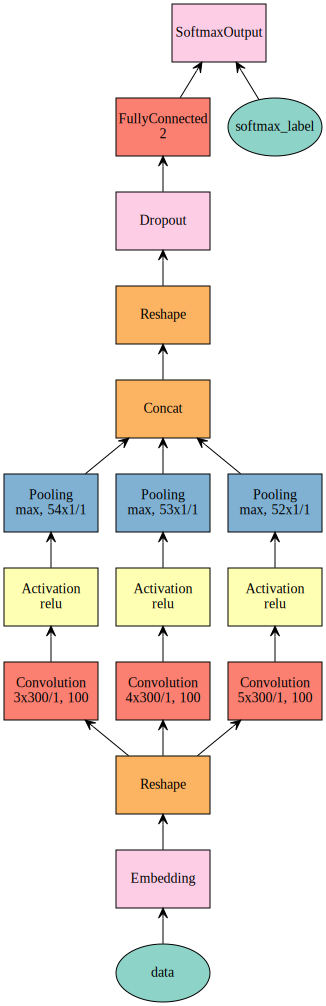

In [73]:
mx.viz.plot_network(sym)